In [5]:
import pandas as pd
import numpy as np
import re
import toolz.itertoolz as itz
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Occupancy Extraction

In [6]:
# Open file as dataframe

fpath = r"C:\Users\student\Downloads\MetaMorpheusVignette\MetaMorpheusVignette\2024-07-01-12-34-36\Task1-SearchTask\AllPSMs.psmtsv"
df = pd.read_csv(fpath, sep='\t', low_memory=False)

fpath2 = r"C:\Users\student\Downloads\MetaMorpheusVignette\MetaMorpheusVignette\2024-07-01-12-34-36\Task1-SearchTask\AllQuantifiedProteinGroups.tsv"
df2 = pd.read_csv(fpath2, sep='\t', low_memory=False)

In [29]:
# Functions

# Gets the offset for counting amino acids from column labeled 'Start and End Residues In Protein'
def get_offset(startend): return int(re.search(r'\d+', startend).group())

# Fragments the column 'Full Sequence' value based on mod ("[" and "]") locations and outputs the amino acid and mod
def get_mod_locs(seq, offset=0):
    if 'Cu[I]' in seq:
        seq = seq.replace('Cu[I]', 'Cu(I)')        
        #print(parts)
    mods = []
    for peptide in seq.split('|'):
        peptide_offset = offset
        parts = re.split("\[|\]", str(peptide))
        try: 
            if '' == parts[0]:
                #mods+=[[parts[2][0]+str(offset), parts[1]]]
                mods+=[[str(peptide_offset), parts[1]]]
                parts=parts[2:]
            for l1, l2 in itz.partition(2, parts):
                #mods+=[[l1[-1] + str(offset+len(l1)-1), l2]]
                mods+=[[str(peptide_offset+len(l1)-1), l2]]
                peptide_offset+=len(l1)
        except:
            print('Error Here:', seq, parts)
        
    if mods: return mods
    else: return [[None, None]]


# Extract the range values of the column 'Start and End Residues In Protein' as integers
def get_range_values(range_str):
    return [int(i) for i in re.findall('\d+', range_str)]

# Creates a dictionary structured as 'Protein Accession'(str) -> 'amino acid number'(int) -> {'mods': {'mod'(str): count(int)} , 'total': count(int)}
def get_occupancy(df):
    occ = {}
    
    grouped_df = df[df['QValue']<=0.01].groupby('Protein Accession')
    for proteins, group in tqdm(grouped_df):
        ranges = {}
        accessions = proteins.split('|')

        for protein in accessions:
            if protein not in occ:
                occ[protein] = {}
                
            for index, row in group.iterrows():
                offset = get_offset(row['Start and End Residues In Protein'])
                mods = list(get_mod_locs(row['Full Sequence'], offset=offset))
                range = row['Start and End Residues In Protein']
    
                #Keep track of ranges to get total counts of amino acids seen
                if range not in ranges:
                    ranges[range] = {'count':0, 
                                     'values':get_range_values(range)}
                ranges[range]['count']+=(row['Full Sequence'].count('|')+1)
                
                #Add/count mods to protein dict
                for mod in mods:
                    if mod[0]:
                        if mod[0] not in occ[protein]:
                            occ[protein][mod[0]] = {'mods':{mod[1]:0}, 'total':0}
                        elif mod[1] not in occ[protein][mod[0]]['mods']:
                            occ[protein][mod[0]]['mods'][mod[1]]=0
                        occ[protein][mod[0]]['mods'][mod[1]]+=1
    
            #Add total aa observation count
            for aa in occ[protein]:
                for range in ranges:
                    if ranges[range]['values'][0] <= float(aa) <= ranges[range]['values'][1]:
                        occ[protein][aa]['total']+=ranges[range]['count']
        
    return occ

# Creates a summary output for a given protein similar to Metamorpheus' occupancy report in the AllProteinGroups.tsv file
def protein_occupancy_summary(occupancy_dict, protein_accession):
    for aa in tqdm(sorted(occupancy_dict[protein_accession])):
        for mod in occupancy_dict[protein_accession][aa]['mods']:
            occ=occupancy_dict[protein_accession][aa]['mods'][mod]/occupancy_dict[protein_accession][aa]['total']
            print('aa#{} [{}]: Occupancy={:.2f}({}/{})'.format(aa, mod, occ, occupancy_dict[protein_accession][aa]['mods'][mod], occupancy_dict[protein_accession][aa]['total']))

# Uses a string as a randomization seed and outputs random rgba values for that string
def string2rgba(string):
    random.seed(string)
    vals = [random.random() for i in range(4)]
    return vals

In [30]:
occ = get_occupancy(df)
#occ['P55095']

  0%|          | 0/2964 [00:00<?, ?it/s]

In [31]:
protein_occupancy_summary(occ, 'Q9ERD7') # Specify 'Protein Accession' here

  0%|          | 0/3 [00:00<?, ?it/s]

aa#293 [Common Variable:Oxidation on M]: Occupancy=0.25(2/8)
aa#354 [Common Fixed:Carbamidomethyl on C]: Occupancy=0.50(3/6)
aa#73 [Common Variable:Oxidation on M]: Occupancy=0.22(6/27)


In [6]:
#df2 = df[(df['Protein Accession']=='P55095') & (df['QValue']<=0.01)]

## Occupancy Visualization

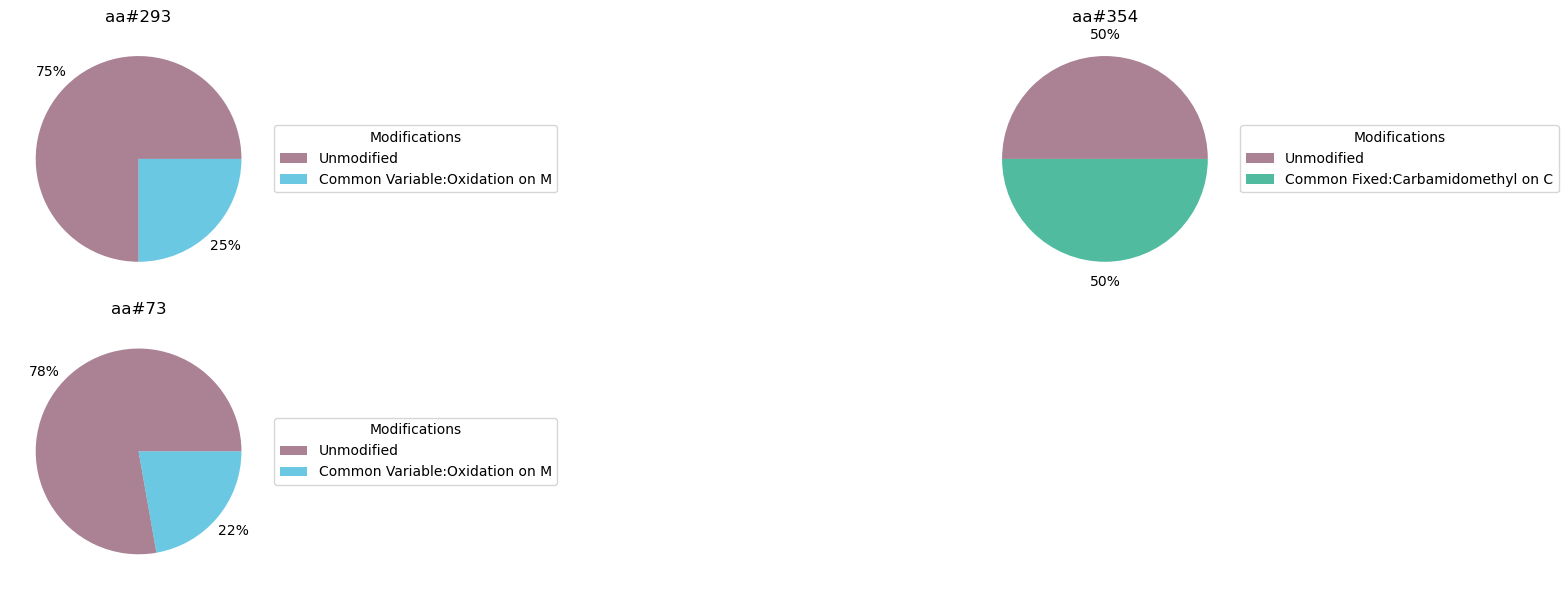

In [32]:
protein = 'Q9ERD7' # Specify 'Protein Accession' here. Another good one is P52480.
n = len(occ[protein])
shape = (n//2+n%2, 2)

fig, axes = plt.subplots(*(shape), figsize=(20,n*2), layout='tight')

axes = np.ravel(axes)
fig.subplots_adjust(wspace=0, hspace=0)
if n//2!=0:
    axes[-1].set(visible=False)

for ind, aa in enumerate(sorted(occ[protein])):
    axes[ind].set_title('aa#{}'.format(aa))
    values = list(np.array(list(occ[protein][aa]['mods'].values()))/occ[protein][aa]['total'])
    labels = occ[protein][aa]['mods'].keys()
    if np.sum(values)!=1:
        values=[1-np.sum(values)]+values
        labels = ['Unmodified', *occ[protein][aa]['mods'].keys()]
    
    pie = axes[ind].pie(values,
                        #labels=labels, 
                        normalize=False, 
                        wedgeprops={'alpha':0.7}, 
                        colors=[string2rgba(i) for i in labels], 
                        autopct=lambda x: '{:.0f}%'.format(x),
                        pctdistance=1.2)
    axes[ind].legend(pie[0], 
                     labels, 
                     title='Modifications',
                     loc='center left', 
                     bbox_to_anchor=(1, 0, 0.5, 1))


In [9]:
all_pg = []
prots = []
for ind, i in df.iterrows():
    if '|' in i['Protein Accession']:
        all_pg+=i['Protein Accession'].split('|')
    else:
        prots+=[i['Protein Accession']]
len(all_pg), len(set(all_pg)), len(prots), len(set(prots)), len(set(prots+all_pg))

(4040, 749, 23690, 7775, 8230)